<a href="https://colab.research.google.com/github/comparativechrono/Principles-of-Data-Science/blob/main/Week_11/AD_analysis_with_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00


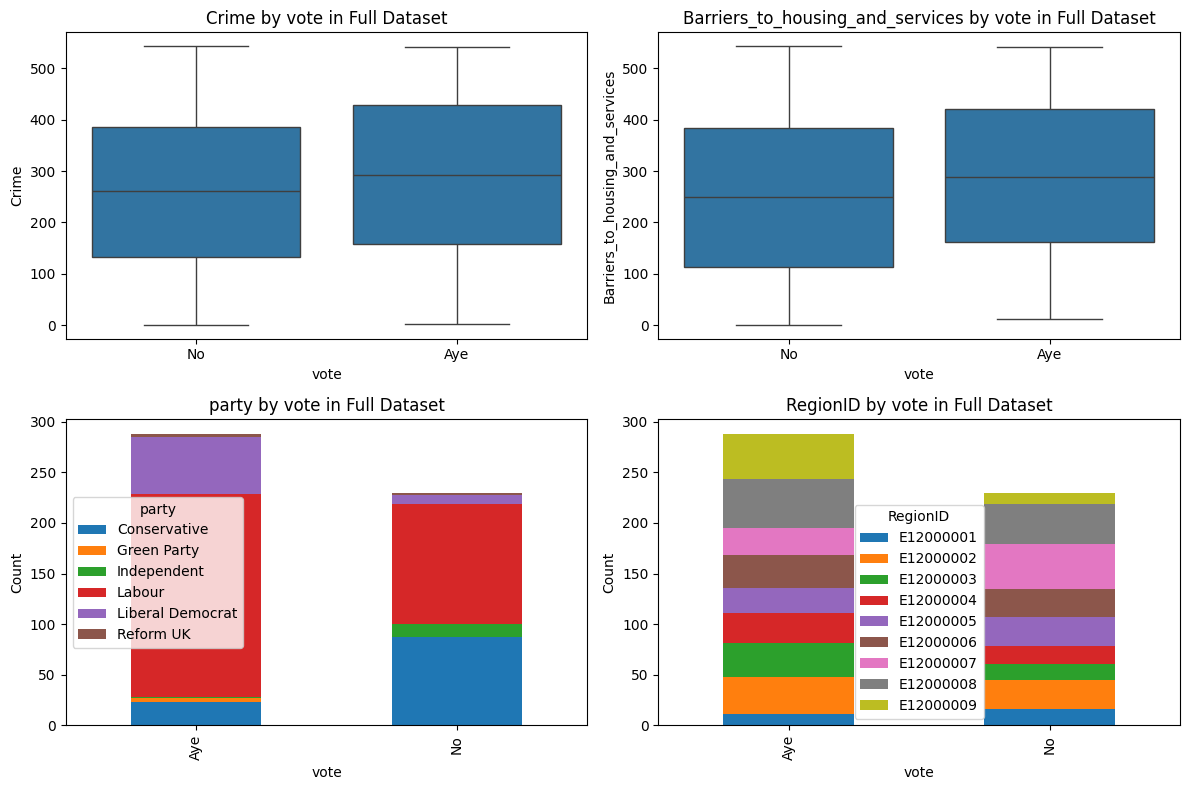

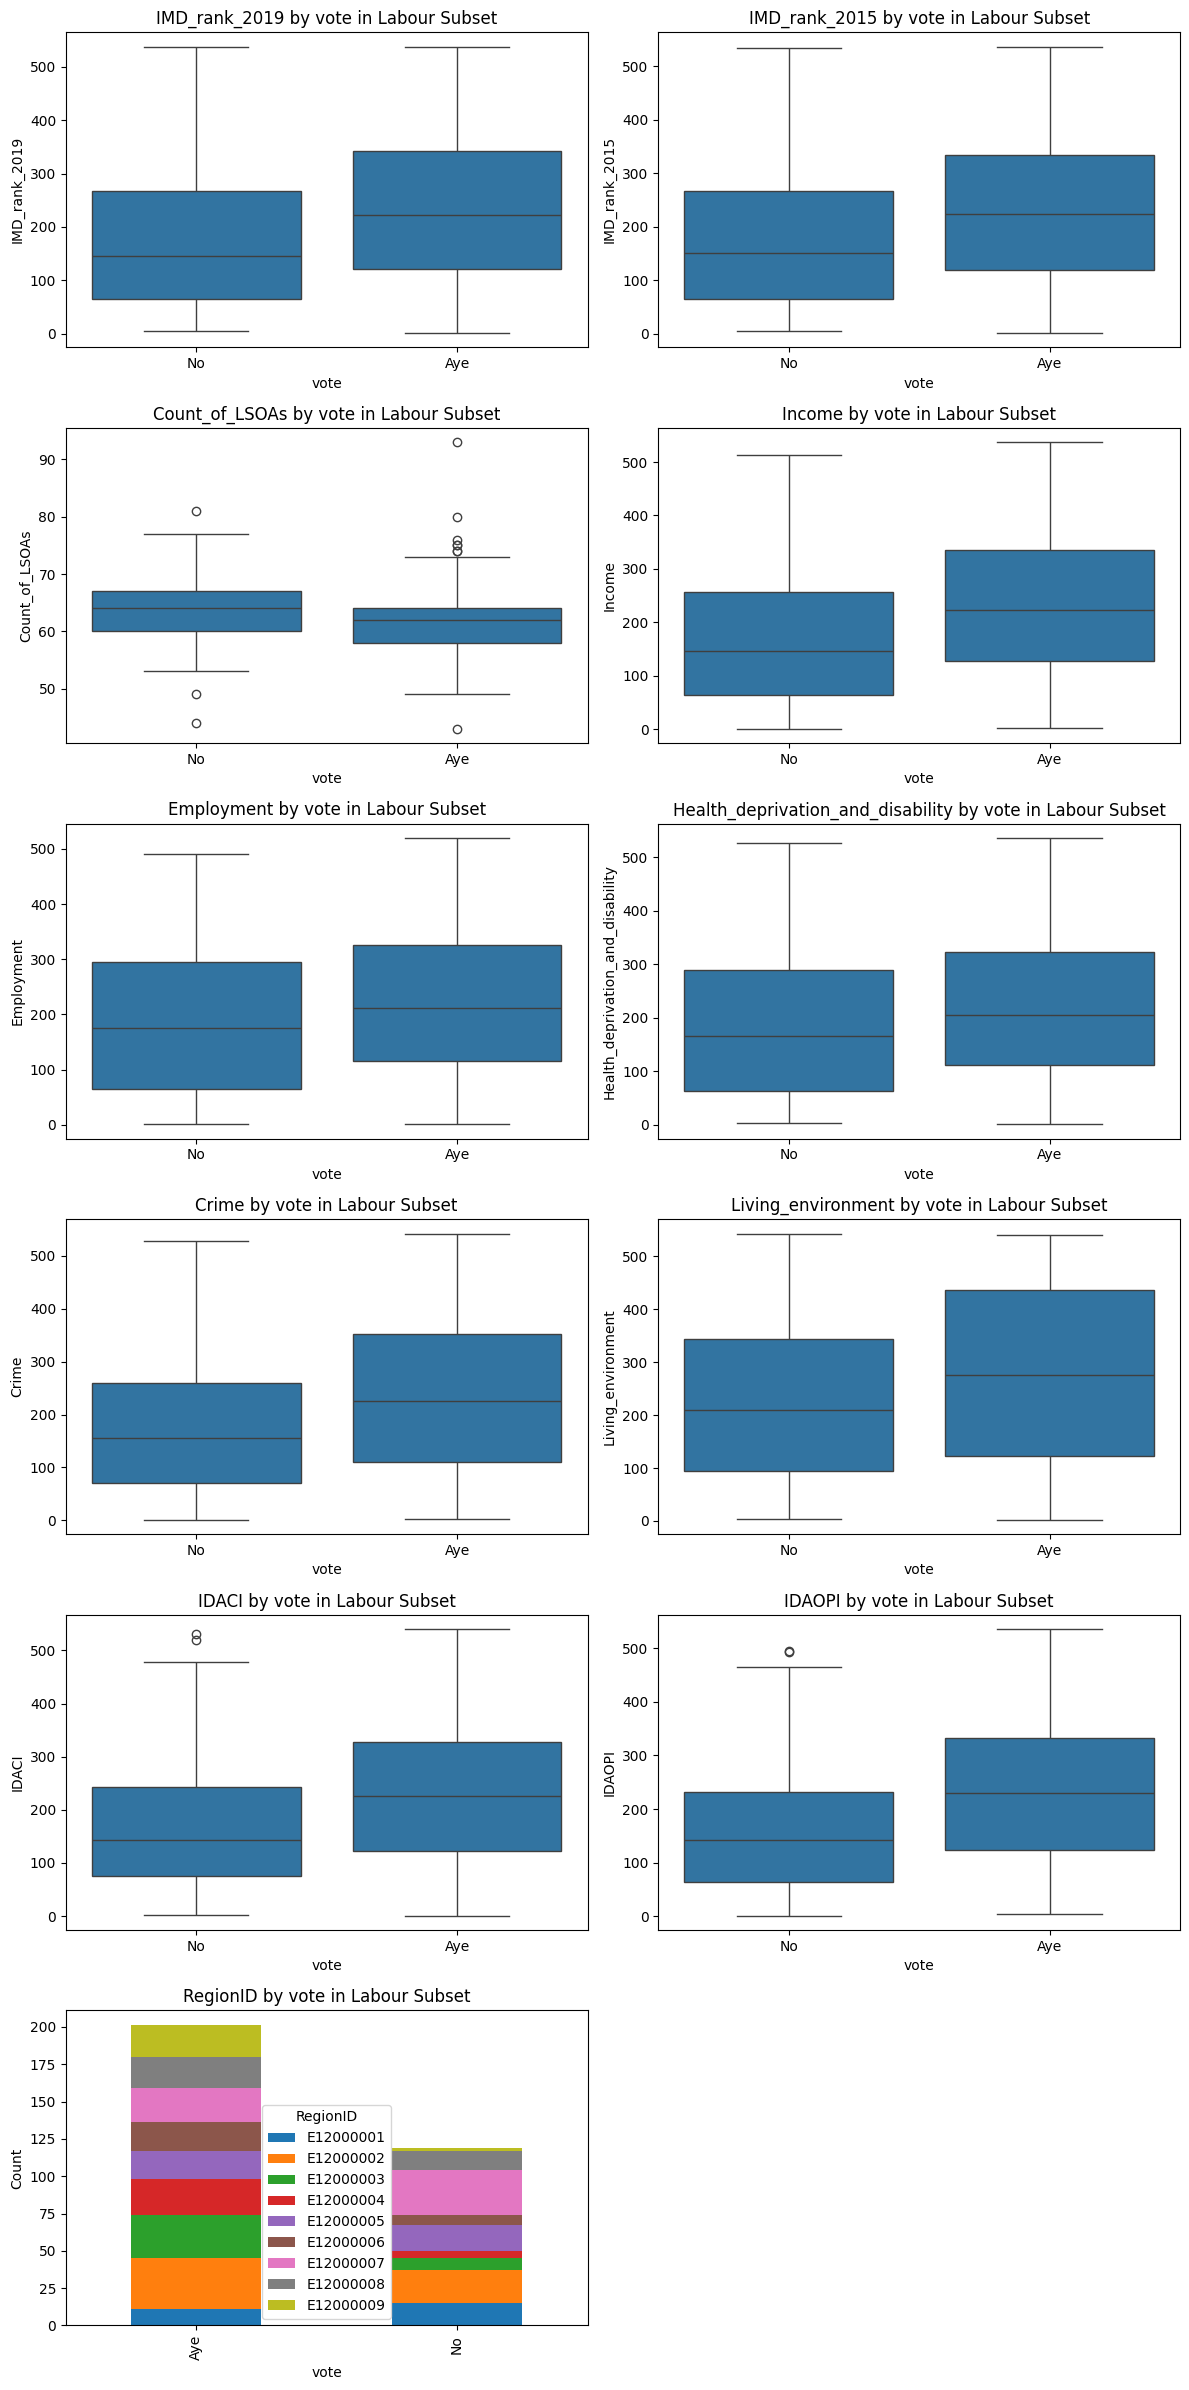

In [ ]:
import pandas as pd
from scipy.stats import shapiro, levene, kruskal, f_oneway, chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.tree import plot_tree
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet

# Load the dataset
file_path = 'AD_data.csv'
data = pd.read_csv(file_path)

# Clean the data: Remove "Teller - Ayes", "Teller - Noes", and "No Vote Recorded" categories
data = data[~data['vote'].isin(['Teller - Ayes', 'Teller - Noes', 'No Vote Recorded'])]

# Identify numerical and categorical fields
numerical_predictors = data.select_dtypes(include=[float, int]).columns.tolist()
categorical_predictors = data.select_dtypes(include=['object']).columns.tolist()
categorical_predictors.remove('vote')  # Exclude target variable
target_variable = 'vote'

# Function to perform hypothesis testing
def hypothesis_testing(data, numerical_predictors, categorical_predictors, target_variable):
    results = {
        'normality': {},
        'levene': {},
        'anova': {},
        'kruskal': {},
        'chi2': {}
    }

    for predictor in numerical_predictors:
        # Check normality using Shapiro-Wilk
        stat, p_value = shapiro(data[predictor])
        results['normality'][predictor] = {'Shapiro-Wilk Statistic': stat, 'p-value': p_value}

        groups = [data[data[target_variable] == vote][predictor] for vote in data[target_variable].unique()]

        # Check homogeneity of variances using Levene's test
        if all(len(group) > 0 for group in groups):
            stat, p_value = levene(*groups)
            results['levene'][predictor] = {'Levene Statistic': stat, 'p-value': p_value}

            # Use ANOVA or Kruskal-Wallis based on assumptions
            if results['normality'][predictor]['p-value'] > 0.05 and results['levene'][predictor]['p-value'] > 0.05:
                stat, p_value = f_oneway(*groups)
                results['anova'][predictor] = {'F Statistic': stat, 'p-value': p_value}
            else:
                stat, p_value = kruskal(*groups)
                results['kruskal'][predictor] = {'Kruskal-Wallis Statistic': stat, 'p-value': p_value}

    for predictor in categorical_predictors:
        contingency_table = pd.crosstab(data[target_variable], data[predictor])
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        results['chi2'][predictor] = {'Chi2 Statistic': chi2_stat, 'p-value': p_value, 'Degrees of Freedom': dof}

    return results

# Perform hypothesis testing for full dataset and Labour subset
full_results = hypothesis_testing(data, numerical_predictors, categorical_predictors, target_variable)
labour_data = data[data['party'] == 'Labour']
labour_results = hypothesis_testing(labour_data, numerical_predictors, categorical_predictors, target_variable)

# Random Forest Analysis
def random_forest_analysis(data, features, target, dataset_type):
    X = data[features]
    y = LabelEncoder().fit_transform(data[target])
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X, y)

    tree_filename = f"{dataset_type}_Random_Forest_Tree.png"
    plt.figure(figsize=(16, 10))
    plot_tree(rf_clf.estimators_[0], feature_names=features, class_names=data[target].unique(), filled=True)
    plt.title(f"Random Forest Decision Tree ({dataset_type})")
    plt.savefig(tree_filename)
    plt.close()

    feature_importances = pd.DataFrame({
        'Feature': features,
        'Importance': rf_clf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    return rf_clf, feature_importances, tree_filename

# Call Random Forest for Full Dataset and Labour Subset
features = data.select_dtypes(include=[float, int]).columns.tolist()
full_rf_clf, full_rf_importances, full_tree_file = random_forest_analysis(data, features, target_variable, "Full Dataset")
labour_rf_clf, labour_rf_importances, labour_tree_file = random_forest_analysis(labour_data, features, target_variable, "Labour Subset")

# Generate Visualizations for Numerical and Categorical Variables
def generate_grid_visualizations(data, test_results, target_variable, dataset_type):
    """
    Generate visualizations for significant variables (numerical and categorical).

    Parameters:
    - data: DataFrame containing the dataset.
    - test_results: Dictionary of hypothesis test results.
    - target_variable: Name of the target variable.
    - dataset_type: Type of dataset (e.g., "Full Dataset" or "Labour Subset").

    Returns:
    - Matplotlib Figure containing all plots.
    """
    # Collect significant numerical and categorical variables
    significant_numerical = [var for var, res in test_results['anova'].items() if res['p-value'] < 0.05] + \
                            [var for var, res in test_results['kruskal'].items() if res['p-value'] < 0.05]
    significant_categorical = [var for var, res in test_results['chi2'].items() if res['p-value'] < 0.05]

    # Total number of plots
    total_vars = len(significant_numerical) + len(significant_categorical)
    cols = 2
    rows = (total_vars // cols) + (total_vars % cols > 0)

    # Create the grid for all plots
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
    axes = axes.flatten()

    # Generate boxplots for significant numerical variables
    plot_idx = 0
    for var in significant_numerical:
        sns.boxplot(data=data, x=target_variable, y=var, ax=axes[plot_idx])
        axes[plot_idx].set_title(f'{var} by {target_variable} in {dataset_type}')
        axes[plot_idx].set_xlabel(target_variable)
        axes[plot_idx].set_ylabel(var)
        plot_idx += 1

    # Generate bar plots for significant categorical variables
    for var in significant_categorical:
        contingency_table = pd.crosstab(data[target_variable], data[var])
        contingency_table.plot(kind='bar', stacked=True, ax=axes[plot_idx])
        axes[plot_idx].set_title(f'{var} by {target_variable} in {dataset_type}')
        axes[plot_idx].set_xlabel(target_variable)
        axes[plot_idx].set_ylabel('Count')
        axes[plot_idx].legend(title=var)
        plot_idx += 1

    # Remove unused axes
    for j in range(plot_idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    return fig


full_fig = generate_grid_visualizations(data, full_results, target_variable, "Full Dataset")
full_fig.savefig('full_dataset_visualizations.png')
labour_fig = generate_grid_visualizations(labour_data, labour_results, target_variable, "Labour Subset")
labour_fig.savefig('labour_dataset_visualizations.png')

from PIL import Image as PilImage
from reportlab.platypus import Image as ReportLabImage

# Function to insert images with dynamic sizing
def add_image_to_story(image_path, story, max_width=500, max_height=500):
    """
    Adds an image to the story with dynamically calculated dimensions.

    Parameters:
    - image_path: Path to the image file.
    - story: The list to which the image will be added.
    - max_width: The maximum width for the image in the PDF.
    - max_height: The maximum height for the image in the PDF.
    """
    try:
        with PilImage.open(image_path) as img:
            img_width, img_height = img.size

            # Calculate the scaling factor to fit the image within max dimensions
            scale = min(max_width / img_width, max_height / img_height, 1)
            display_width = img_width * scale
            display_height = img_height * scale

            # Add the image to the story
            story.append(ReportLabImage(image_path, width=display_width, height=display_height))
            story.append(Spacer(1, 12))
    except Exception as e:
        print(f"Error adding image {image_path}: {e}")


from reportlab.platypus import Table, TableStyle, Paragraph
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

# Function to generate and format the table with text wrapping
def generate_significant_variables_table(results, dataset_type):
    """
    Generate a summary table of significant variables for a dataset with text wrapping.

    Parameters:
    - results: Dictionary containing test results.
    - dataset_type: String indicating dataset type (e.g., "Full Dataset").

    Returns:
    - Table data sorted by p-value, including test type and interpretations with text wrapping.
    """
    styles = getSampleStyleSheet()
    table_data = [["Variable", "Test", "Statistic", "p-Value", "Interpretation"]]
    rows = []

    # Add significant ANOVA results
    for var, result in results['anova'].items():
        if result['p-value'] < 0.05:
            rows.append([
                var,
                "ANOVA",
                f"F = {result['F Statistic']:.4f}",
                f"{result['p-value']:.4f}",
                Paragraph(
                    f"Significant differences across vote categories in {dataset_type}. "
                    f"Higher values of '{var}' are associated with specific vote categories.",
                    styles['Normal']
                ),
            ])

    # Add significant Kruskal-Wallis results
    for var, result in results['kruskal'].items():
        if result['p-value'] < 0.05:
            rows.append([
                var,
                "Kruskal-Wallis",
                f"H = {result['Kruskal-Wallis Statistic']:.4f}",
                f"{result['p-value']:.4f}",
                Paragraph(
                    f"Non-parametric differences in {dataset_type}. '{var}' shows variability "
                    f"across voting categories.",
                    styles['Normal']
                ),
            ])

    # Add significant Chi-Square results
    for var, result in results['chi2'].items():
        if result['p-value'] < 0.05:
            rows.append([
                var,
                "Chi-Square",
                f"Chi2 = {result['Chi2 Statistic']:.4f}",
                f"{result['p-value']:.4f}",
                Paragraph(
                    f"Association with vote categories in {dataset_type}. '{var}' plays a role in "
                    f"voting outcomes.",
                    styles['Normal']
                ),
            ])

    # Sort rows by p-value
    rows.sort(key=lambda x: float(x[3]))
    table_data.extend(rows)

    return table_data


# Add tables to the PDF with improved formatting and text wrapping
def add_table_to_story(table_data, story):
    """
    Adds a formatted table to the PDF story with text wrapping.

    Parameters:
    - table_data: List of lists representing the table data.
    - story: The list to which the table will be added.
    """
    # Create a table with alternating row colors
    table = Table(table_data, repeatRows=1, colWidths=[100, 100, 100, 80, 220])  # Adjust column widths
    table_style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),  # Header background
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),  # Header text color
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, -1), 10),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),  # Body row colors
        ('ROWBACKGROUNDS', (0, 1), (-1, -1), [colors.beige, colors.whitesmoke]),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('VALIGN', (0, 0), (-1, -1), 'TOP'),  # Align text to the top
    ])
    table.setStyle(table_style)

    # Add the table and spacer to the story
    story.append(table)
    story.append(Spacer(1, 12))





# Generate PDF Report
def generate_pdf_report(full_results, labour_results, full_rf_importances, labour_rf_importances, full_tree_file, labour_tree_file):
    doc = SimpleDocTemplate("Assisted_Dying_Report.pdf", pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    story.append(Paragraph("Assisted Dying Report", styles['Title']))
    story.append(Spacer(1, 12))

    # Add Full Dataset Interpretation
    story.append(Paragraph("Full Dataset Analysis:", styles['Heading2']))
    full_table_data = generate_significant_variables_table(full_results, "Full Dataset")
    story.append(Paragraph(
    "The tables below summarize statistically significant variables identified through hypothesis testing for all MPs. "
    "For numerical variables, ANOVA or Kruskal-Wallis tests were applied based on data characteristics, "
    "while categorical variables were analyzed using Chi-Square tests. The significance level is set at 0.05.",
    styles['Normal']
    ))
    story.append(Spacer(1, 12))
    add_table_to_story(full_table_data, story)
    for predictor, result in full_results['anova'].items():
        if result['p-value'] < 0.05:
            story.append(Paragraph(
                f"'{predictor}' shows significant differences across vote categories "
                f"(ANOVA: F = {result['F Statistic']:.4f}, p = {result['p-value']:.4f}). "
                f"Higher values of '{predictor}' are associated with specific vote categories, "
                f"suggesting {predictor}'s role in influencing votes.",
                styles['Normal']
            ))
    for predictor, result in full_results['kruskal'].items():
        if result['p-value'] < 0.05:
            story.append(Paragraph(
                f"'{predictor}' shows significant differences across vote categories "
                f"(Kruskal-Wallis: H = {result['Kruskal-Wallis Statistic']:.4f}, p = {result['p-value']:.4f}). "
                f"This indicates non-parametric differences in '{predictor}' across voting groups.",
                styles['Normal']
            ))

    # Add Visualizations for Full Dataset
    story.append(Paragraph("Visualizations for Full Dataset:", styles['Heading3']))
    add_image_to_story('full_dataset_visualizations.png', story)
    add_image_to_story(full_tree_file, story)
    story.append(Spacer(1, 12))

    # Add Labour Subset Interpretation
    story.append(Paragraph("Labour Subset Analysis:", styles['Heading2']))
    labour_table_data = generate_significant_variables_table(labour_results, "Labour Subset")
    story.append(Paragraph(
    "The tables below summarize statistically significant variables identified through hypothesis testing for only Labour MPs. "
    "For numerical variables, ANOVA or Kruskal-Wallis tests were applied based on data characteristics, "
    "while categorical variables were analyzed using Chi-Square tests. The significance level is set at 0.05.",
    styles['Normal']
    ))
    story.append(Spacer(1, 12))
    add_table_to_story(labour_table_data, story)
    for predictor, result in labour_results['anova'].items():
        if result['p-value'] < 0.05:
            story.append(Paragraph(
                f"'{predictor}' shows significant differences across vote categories "
                f"(ANOVA: F = {result['F Statistic']:.4f}, p = {result['p-value']:.4f}). "
                f"Higher values are linked to specific voting behaviors in Labour constituencies.",
                styles['Normal']
            ))
    for predictor, result in labour_results['kruskal'].items():
        if result['p-value'] < 0.05:
            story.append(Paragraph(
                f"'{predictor}' shows significant differences across vote categories "
                f"(Kruskal-Wallis: H = {result['Kruskal-Wallis Statistic']:.4f}, p = {result['p-value']:.4f}). This suggests that '{predictor}' varies significantly across voting groups, "
                f"indicating its potential impact on vote choices in Labour constituencies.",
                styles['Normal']
            ))

    # Add Visualizations for Labour Subset
    story.append(Paragraph("Visualizations for Labour Subset:", styles['Heading3']))
    add_image_to_story('labour_dataset_visualizations.png', story)
    add_image_to_story(labour_tree_file, story)
    story.append(Spacer(1, 12))

    # Add Random Forest Insights
    story.append(Paragraph("Random Forest Insights:", styles['Heading2']))
    story.append(Paragraph(
    "Random Forest models were used to identify the most influential variables affecting voting behavior. "
    "The top predictors, ranked by their importance scores, are listed below for both the full dataset and "
    "the Labour subset. These variables contribute the most to the model's predictive accuracy.",
    styles['Normal']
    ))
    story.append(Spacer(1, 12))
    story.append(Paragraph("Top Predictors for Full Dataset:", styles['Heading3']))
    for i, row in full_rf_importances.head(3).iterrows():
        story.append(Paragraph(
            f"{i + 1}. '{row['Feature']}' has an importance score of {row['Importance']:.4f}, "
            f"indicating its strong influence on voting behavior in the full dataset.",
            styles['Normal']
        ))

    story.append(Paragraph("Top Predictors for Labour Subset:", styles['Heading3']))
    for i, row in labour_rf_importances.head(3).iterrows():
        story.append(Paragraph(
            f"{i + 1}. '{row['Feature']}' has an importance score of {row['Importance']:.4f}, "
            f"highlighting its significant impact on voting outcomes in Labour constituencies.",
            styles['Normal']
        ))

    # Build PDF
    doc.build(story)

# Generate the PDF Report
generate_pdf_report(
    full_results, labour_results,
    full_rf_importances, labour_rf_importances,
    full_tree_file, labour_tree_file
)
